In [2]:

from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt 
#from scipy.special import ellipk, ellipe, elliprf, elliprj 
from scipy.integrate import quad
from scipy.spatial.transform import Rotation 
import scipy.optimize
import pandas as pd
import sklearn
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator 
 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import einops as eo
import joblib
import dill 
import time
from functools import partial
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import sys


x = jax.random.uniform(jax.random.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype # --> dtype('float64')
%matplotlib widget

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def ellipp(n, m):
    n, m = (np.asarray(x) for x in (n, m))
    if np.any(m >= 1):
        raise ValueError("m must be < 1")
    y = 1 - m
    rf = elliprf(0, y, 1)
    rj = elliprj(0, y, 1, 1 - n)
    return rf + rj * n / 3

@jax.jit
#assumes p is positive
def ellipc(kc, p, c, s):
    kc = jnp.asarray(kc, dtype=jnp.float64)
    p = jnp.asarray(p, dtype=jnp.float64)
    c = jnp.asarray(c, dtype=jnp.float64)
    s = jnp.asarray(s, dtype=jnp.float64)
    #print(p[p<=0])
    #if jnp.any(jnp.equal(kc,0)):
    #    raise ValueError("kc cannot be 0.")
    errtol=1e-10
    k = jnp.abs(kc)

    pp = p.copy()
    cc = c.copy()
    ss = s.copy() 
    em = 1.
    cond = p>0 

    #pp = pp.at[cond].set(jnp.sqrt(p[cond]))
    #ss = ss.at[cond].set((s/pp)[cond])
    pp = jnp.where(cond, jnp.sqrt(p), pp)
    ss = jnp.where(cond, s/pp, ss)
    #if not jnp.min(p, axis=None)>0:
    #    f = kc[~cond]**2 
    #    q = 1 - f
    #    g = 1 - pp[~cond]
    #    f = f - pp[~cond]
    #    q = q*(ss[~cond]-c[~cond]*pp[~cond])
    #    #pp = pp.at[~cond].set(np.sqrt(f/g))
    #    pp = jnp.where(~cond, jnp.sqrt(f/g), pp)
    #    cc = (c[~cond]-ss[~cond])/g
    #    #ss = ss.at[~cond].set(-q/(pp[~cond]*g**2+cc*pp[~cond]))
    #    ss = jnp.where(~cond, -q/(pp[~cond]*g**2+cc*pp[~cond]), ss)
    f = cc.copy()
    cc = cc + ss/pp
    g = k/pp
    ss = 2*(ss+f*g)
    pp = g + pp
    g = em
    em = k + em
    kk = k.copy()
    #while(jnp.max(jnp.abs((g-k)/g))>errtol):
    for i in range(10):
        k = 2*jnp.sqrt(kk)
        kk = k*em
        f = cc.copy()
        cc = cc + ss/pp
        g = kk/pp
        ss = 2*(ss+f*g)
        pp = g + pp
        g = em.copy()
        em = k + em
    return (jnp.pi/2)*(ss+cc*em)/(em*(em+pp))

def ellipc_np(kc, p, c, s):
    kc, p, c, s = (np.asarray(x, dtype = np.float64) for x in (kc, p, c, s))
    #print(p[p<=0])
    if np.any(kc==0):
        raise ValueError("kc cannot be 0.")
    errtol=1e-10
    k = np.abs(kc)

    pp = p.copy()
    cc = c.copy()
    ss = s.copy() 
    em = 1.
    cond = p>0 

    pp[cond] = np.sqrt(p[cond])
    ss[cond] = (s/pp)[cond]

    if np.any(~cond):
        f = kc[~cond]**2 
        q = 1 - f
        g = 1 - pp[~cond]
        f = f - pp[~cond]
        q = q*(ss[~cond]-c[~cond]*pp[~cond])
        pp[~cond] = np.sqrt(f/g)
        cc = (c[~cond]-ss[~cond])/g
        ss[~cond] = (-q/(pp[~cond]*g**2+cc*pp[~cond]))
    f = cc.copy()
    cc = cc + ss/pp
    g = k/pp
    ss = 2*(ss+f*g)
    pp = g + pp
    g = em
    em = k + em
    kk = k.copy()
    while(np.any(np.abs(g-k)>g*errtol)):
        k = 2*np.sqrt(kk)
        kk = k*em
        f = cc.copy()
        cc = cc + ss/pp
        g = kk/pp
        ss = 2*(ss+f*g)
        pp = g + pp
        g = em.copy()
        em = k + em
    return (np.pi/2)*(ss+cc*em)/(em*(em+pp))
 
def test_ellipc(n, k):
    m = k**2
    kc = np.sqrt(1-m)
    elliptic = np.array([ellipk(m), ellipe(m), ellipp(n, m)])
    arg1 = np.array([kc, kc, kc])
    arg2 = np.array([1, 1, -n+1])
    arg3 = np.array([1, 1, 1])
    arg4 = np.array([1, kc**2, 1])

    elliptic_results = ellipc(arg1, arg2, arg3, arg4)
    test_1 = np.allclose(elliptic, elliptic_results, 1e-7) 
    return test_1
    
@jax.jit
def alpha(xi, rr, R):
    return R/(jnp.sqrt(xi**2 +(rr+R)**2 ))
@jax.jit
def beta(xi, rr, R):
    return xi/(jnp.sqrt(xi**2 +(rr+R)**2 ))

@jax.jit
def k(xi, rr, R):
    num = (xi**2 + (R-rr)**2)
    den = (xi**2 + (R+rr)**2)
    return jnp.sqrt(num/den)

def Br_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))

    xi_p, xi_m = zz+L, zz-L
    alpha_p, alpha_m = alpha(xi_p, rr, R), alpha(xi_m, rr, R)


    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Br = (M*R/np.pi)* (alpha_p*ellipc(kp, 1, 1, -1) - alpha_m*ellipc(km, 1, 1, -1))
    return Br

def Bz_polar_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))
    xi_p, xi_m = zz+L, zz-L
    beta_p, beta_m = beta(xi_p, rr, R), beta(xi_m, rr, R)
    gamma = (R-rr)/(R+rr)

    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Bz = (R*M/(np.pi*(rr+R))) * (beta_p*ellipc(kp, gamma**2, 1, gamma) - beta_m*ellipc(km, gamma**2, 1, gamma))
    return Bz


def Bxyz_func(xx, yy, zz, R=3, L=2, C=1e3):
    tt = np.arctan2(yy,xx)
    rr = np.sqrt(xx**2 + yy**2)
    Br = Br_func(rr, zz, R, L, C)
    Bx = Br * np.cos(tt)
    By = Br * np.sin(tt)
    Bz = Bz_polar_func(rr, zz, R, L, C)
    return Bx, By, Bz

#def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    Bx = Br * np.cos(tt)
#    return Bx

#def By_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    By = Br * np.sin(tt)
#    return By

#def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
#    rr = np.sqrt(xx**2 + yy**2)
#    Bz = Bz_polar_func(rr, zz, R, L, C)
#    return Bz

def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[0]

def By_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[1]

def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[2]

def Bx(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz


def Bx_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz

In [5]:
folder = "data/PIM_03202023"
file_name = "DataAvg.txt"
file = f"{folder}/{file_name}"

shape_points = {"i":7*10+1,"j": 7*10+1,"k": 6*5+2}

df = pd.read_csv(file).sort_values(["z", "y", "x"])

X = np.array(df.loc[:, "x":"z"]) # unpacks to x, y, z
M = np.array(df.loc[:, "Mx":"Mz"])
df


,Unnamed: 0,x,y,z,Mx,My,Mz,Mx_std,My_std,Mz_std
160572,160572,-7.0,-7.0,0.0,0.068558,0.418323,-1.930507,0.001319,0.001535,0.001424
49138,49138,-6.8,-7.0,0.0,0.068072,0.417397,-1.932107,0.001227,0.001572,0.001746
121046,121046,-6.6,-7.0,0.0,0.065018,0.416864,-1.932594,0.001270,0.001299,0.001559
52040,52040,-6.4,-7.0,0.0,0.059892,0.416069,-1.934286,0.001357,0.001475,0.001304
92501,92501,-6.2,-7.0,0.0,0.054047,0.415682,-1.934872,0.001380,0.001372,0.001505
...,...,...,...,...,...,...,...,...,...,...
115801,115801,6.2,7.0,6.2,-0.292032,-0.254717,-0.858372,0.001425,0.001259,0.001627
159086,159086,6.4,7.0,6.2,-0.296463,-0.252376,-0.853248,0.001262,0.001415,0.001377
98152,98152,6.6,7.0,6.2,-0.301324,-0.250497,-0.848621,0.001329,0.001920,0.001643
17969,17969,6.8,7.0,6.2,-0.304914,-0.248203,-0.842591,0.001185,0.001268,0.001478


In [6]:
import numpy as np
import magpylib as magpy
import pyvista as pv

pv.set_jupyter_backend('client') # improve rending in a jupyter notebook

coil1 = magpy.Collection()
#for z in np.linspace(-8, 8, 16):
#    winding = magpy.current.Loop(
#        current=100,
#        diameter=2,
#        position=(0,0,z),
#    )
#    coil1.add(winding)


grid = pv.UniformGrid(
    dimensions=list(shape_points.values()),
    spacing=(0.2, 0.2, 0.2),
    origin=(-5, -5, 0),
)

# compute B-field and add as data to grid
#grid['B'] = coil1.getB(grid.points)
grid['B'] = M
print(grid['B'].shape)

# compute field lines
seed = pv.Disc(inner=0.2, outer=2, r_res=10, c_res=63)
strl = grid.streamlines_from_source(
    seed,
    vectors='B',
    max_time=180,
    initial_step_length=0.01,
    integration_direction='both',
    progress_bar=True
)

# create plotting scene
pl = pv.Plotter()

# add field lines and legend to scene
legend_args = {
    'title': 'B [mT]',
    'title_font_size': 20,
    'color': 'black',
    'position_y': 0.25,
    'vertical': True,
}

# draw coils
# magpy.show(coil1, canvas=pl, backend='pyvista')

# add streamlines
pl.add_mesh(
    strl.tube(radius=.02),
    cmap="RdBu",
    scalar_bar_args=legend_args,
)
# display scene
pl.camera.position=(160, 10, -10)
pl.set_background("white")
pl.show()

(161312, 3)


Generating Streamlines: 100%|██████████[00:00<00:00]


Widget(value="<iframe src='http://localhost:38233/index.html?ui=P_0x7f0573a32410_0&reconnect=auto' style='widt…

In [7]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import magpylib as magpy
from matplotlib.widgets import Slider, Button
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, interactive_output, HBox, VBox
from IPython.display import display

df_xy = (df[df["z"]==0]) 



M_magnitude = np.linalg.norm(eo.rearrange(M,"(i j k) c -> i j k c", **shape_points), axis=2)

cmap = plt.cm.viridis
norm = plt.Normalize(M_magnitude.min(), M_magnitude.max())

X_z = eo.rearrange(np.array(df_xy.loc[:, "x":"z"]), "(i j) c -> i j c", i=shape_points["i"], j=shape_points["j"])


M_z = eo.rearrange(np.array(df_xy.loc[:, "Mx":"Mz"]), "(i j) c -> i j c", i=shape_points["i"], j=shape_points["j"])
    
x = X_z[:, :, 0]
y = X_z[:, :, 1]

u = M_z[:, :, 1]
v = -M_z[:, :, 0]

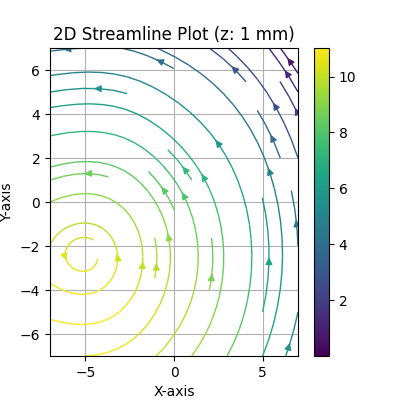

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
#fig.colorbar()

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
#@interact(z=FloatSlider(min=0, max=5, step=0.2, value=1.2, description='z (mm)'))
def plot_streamlines(z):
    df_xy = df[df["z"]==z] 
    X_z = eo.rearrange(np.array(df_xy.loc[:, "x":"z"]), "(i j) c -> i j c", i=shape_points["i"], j=shape_points["j"]) # unpacks to x, y, z
    M_z = eo.rearrange(np.array(df_xy.loc[:, "Mx":"Mz"]), "(i j) c -> i j c", i=shape_points["j"], j=shape_points["i"])
    

    
    x = X_z[:, :, 0]
    y = X_z[:, :, 1]

    u = M_z[:, :, 1]
    v = -M_z[:, :, 0]

    Mz_magnitude = np.linalg.norm(M_z, axis=2)
    
   
    cmap = plt.cm.viridis
    norm = plt.Normalize(Mz_magnitude.min(), Mz_magnitude.max())
    
    
    ax.clear()
    ax.streamplot(x, y, u, v, density=0.5, linewidth=1, color=Mz_magnitude, cmap=cmap)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid()
    ax.set_title(f"2D Streamline Plot (z: {z} mm)")
    # Update the plot
    fig.canvas.draw_idle()
plot_streamlines(1)

    

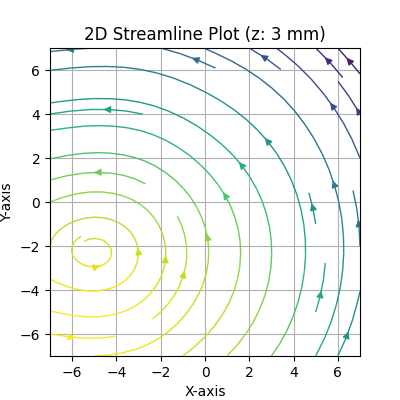

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_streamlines(3)


In [10]:
import scipy as sp
sensor = magpy.Sensor(position=(0,0,0))
magnet = magpy.magnet.Cylinder(magnetization=(0, 0, 1210), dimension=(5, 2))




folder = "data/PIM_03202023"
file_name = "DataAvg.txt"
file = f"{folder}/{file_name}"

shape_points = {"i":7*10+1,"j": 7*10+1,"k": 6*5+2}

df = pd.read_csv(file).sort_values(["z", "y", "x"])


X = np.array(df.loc[:, "x":"z"]) 
M = np.array(df.loc[:, "Mx":"Mz"])


sensor.position = X

def getField(x, sensor, magnet, dx=0.0001):
    xdx = x + dx
    magnet.magnetization=(0,0,x[5])
    magnet.position = x[:3]
    phi = x[3]
    theta = x[4]
    rot = [np.cos(theta/2), np.sin(theta/2)*np.cos(phi), np.sin(theta/2)*np.sin(phi), 0]
    magnet.orientation = sp.spatial.transform.Rotation.from_quat(rot)

    f = magpy.getB(sources=magnet, observers=sensor)
    #xdx = x + dx
    return f
    

def cost(x, B, sensor, magnet):
    diff = getField(x, sensor, magnet)-B
    return np.sum((diff)**2)

guess = np.array([-5,-2,30, np.pi/8, np.pi/4, 1400])

#sol = scipy.optimize.least_squares(cost, x0=guess, args=(M, sensor, magnet), bounds=([-7,-7,30,-np.pi,-np.pi, 1000],[7,7,50,np.pi, np.pi, 2000]))
#sol.x, sol.success


In [11]:
#sol.x, sol.success, sol.message

In [12]:
#360*sol.x[3:5]/(2*np.pi)

In [13]:
#%timeit getField(guess, sensor, magnet)

In [14]:
def C(kc, p, c, s):
    return c*sp.special.elliprf(0,kc**2, 1)+ (1/3)*(c-p*s)*sp.special.elliprj(0, kc**2, 1, p)
%timeit C(0.1, 0.2, 0.3, 0.4)

3.37 µs ± 201 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
 #rot_vec = theta*np.array([np.cos(phi), np.sin(phi), 0])
  #  r = Rotation.from_rotvec(rot_vec)
   # Xrot = r.apply(X.T).T
    #x, y, z = Xrot
    #xin, yin, zin = x-x0, y-y0, z-z0
def B_np(position, R=0.03, L=0.02, Bmax=1.4):
    C=ellipc_np
    xx, yy, zz = position.T
    tt = np.arctan2(yy,xx)
    rr = np.sqrt(xx**2 + yy**2)
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))

    xi_p, xi_m = zz+L, zz-L
    alpha_p, alpha_m = alpha(xi_p, rr, R), alpha(xi_m, rr, R)
    beta_p, beta_m = beta(xi_p, rr, R), beta(xi_m, rr, R)
    gamma = (R-rr)/(R+rr)


    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Br = (M*R/np.pi)* (alpha_p*C(kp, 1, 1, -1) - alpha_m*C(km, 1, 1, -1))
    Bx = Br * np.cos(tt)
    By = Br * np.sin(tt)
    Bz = (R*M/(np.pi*(rr+R))) * (beta_p*C(kp, gamma**2, 1, gamma) - beta_m*C(km, gamma**2, 1, gamma))

    return Br, Bz

@jax.jit
def B_jnp(position, R=0.025, L=0.02, Bmax=1.4):
    C=ellipc
    xx, yy, zz = jnp.asarray(position).T
    tt = jnp.arctan2(yy,xx)
    rr = jnp.sqrt(xx**2 + yy**2)
    M = (Bmax)*(jnp.sqrt(4*L**2 +R**2)/(2*L))

    xi_p, xi_m = zz+L, zz-L
    alpha_p, alpha_m = alpha(xi_p, rr, R), alpha(xi_m, rr, R)
    beta_p, beta_m = beta(xi_p, rr, R), beta(xi_m, rr, R)
    gamma = (R-rr)/(R+rr)


    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Br = (M*R/jnp.pi)* (alpha_p*C(kp, 1, 1, -1) - alpha_m*C(km, 1, 1, -1))
    Bx = Br * jnp.cos(tt)
    By = Br * jnp.sin(tt)
    Bz = (R*M/(jnp.pi*(rr+R))) * (beta_p*C(kp, gamma**2, 1, gamma) - beta_m*C(km, gamma**2, 1, gamma))

    return jnp.array([Bx, By, Bz])

@jax.jit
def B_dipole(position, rotation, M0, shape=(25.4*3/16, 25.4/16)):
    R = jnp.sqrt(jnp.sum(position**2))
    B = (M0*(shape[0]/2)**2 * shape[1] *jnp.pi /( 4*jnp.pi))*((3*position*(jnp.matmul(position, rotation))[:, jnp.newaxis]/R**5)-rotation/R**3)
    return B

@jax.jit
def getField_dipole(x, positions):
    #magnetization=x[5]
    magnetization=1210
    position = x[:3]
    phi = x[3]
    theta = x[4]
    axis = jnp.array([jnp.sin(theta)*jnp.cos(phi), jnp.sin(theta)*jnp.sin(phi), jnp.cos(theta)])
    return B_dipole(positions-position, axis, magnetization)
@jax.jit
def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = jnp.asarray(axis)
        axis = axis / jnp.sqrt(jnp.dot(axis, axis))
        a = jnp.cos(theta / 2.0)
        b, c, d = -axis * jnp.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return jnp.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                        [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                        [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


@jax.jit
def getField_jnp(x, positions):
    magnetization=x[5]
    #magnetization=1200
    position = x[:3]
    phi = x[3]
    theta = x[4]
    axis = jnp.array([jnp.cos(phi), jnp.sin(phi), 0])
    pos_trans = jnp.einsum("i j, k j ->k i" ,rotation_matrix(-axis, -theta), positions)-position
    
    return B_jnp(pos_trans, Bmax=magnetization).T

@jax.jit
def cost_jnp(x, B, positions):            
    diff = getField_jnp(x, positions)-B
    return np.sum((diff)**2)


@jax.jit
def cost_dipole(x, B, positions):
    diff = getField_dipole(x, positions)-B
    return np.sum((diff)**2)


In [16]:
from jax.scipy import optimize
guess = np.array([-1,-1, 40, np.pi/8, np.pi/4])
#sol = optimize.minimize(cost_jnp, x0=guess, args=(M, X), method="BFGS", tol=1e-6, options={"gtol": 1e-6})

In [17]:
#sol.x, sol.status, sol.fun

In [18]:
#360*sol.x[3:5]/(2*np.pi)

In [19]:
guess = np.array([7,7, 40, jnp.pi/3, jnp.pi/3])
cost_with_grad = jax.value_and_grad(cost_dipole)
bounds=([-7,-7,-100,-4*np.pi,-2*np.pi],[7,7,100,4*np.pi, 2*np.pi])
bounds = list(zip(*bounds))
sol = scipy.optimize.minimize(cost_with_grad, x0=guess, args=(M, X), jac=True, bounds=bounds, tol=1e-1000)
sol.x, sol.success

(array([-6.49072029e-06, -7.13556978e-06,  3.09998510e+00, -2.68724673e+00,
        -1.86226425e-01]),
 True)

In [20]:
sol.x, sol.status, sol.fun, 

(array([-6.49072029e-06, -7.13556978e-06,  3.09998510e+00, -2.68724673e+00,
        -1.86226425e-01]),
 0,
 330424.7166236918)

In [21]:
360*sol.x[3:5]/(2*np.pi)

array([-153.96789615,  -10.6699882 ])

In [22]:
diff = np.abs(getField_dipole(sol.x, X)-M)
np.max(diff), np.min(diff), np.mean(diff)

(1.9758408007690793, 1.1930840041576018e-06, 0.6046057029649032)

In [23]:
sol = scipy.optimize.minimize(cost_with_grad, x0=guess, args=(M[::], X[::]), jac=True, bounds=bounds, tol=1e-1000)
sol.x, sol.success

(array([-6.49072029e-06, -7.13556978e-06,  3.09998510e+00, -2.68724673e+00,
        -1.86226425e-01]),
 True)

In [24]:
360*sol.x[3:5]/(2*np.pi)

array([-153.96789615,  -10.6699882 ])

In [116]:
data = pd.read_csv(f"data/PIM04142023/DataAvg.txt", header=[0,1, 2], index_col=[0])
data = data.sort_values(by=list(filter(lambda x: x[0]=="Magnet", data.columns.to_list()))[::-1])
sensor_positions = pd.DataFrame(np.array([[0., 0., 0.], [35., 0., 0.], [0., 35., 0.], [35., 35., 0.]]), columns=pd.MultiIndex.from_product([["Sensor"], ["x", "y", 'z'], ["position"]]))
idx=pd.IndexSlice
new = pd.concat([data.loc[:, idx["Magnet", :, :]], sensor_positions], axis=1).swaplevel(i=0, j=-1, axis=1)
new.columns.set_levels(["Positions"], level=0, inplace=True)
new
data=pd.concat([data.loc[:, idx["Magnetometer", :, :]], new], axis=1)
data

values Magnetometer                                                    \
axis              x                   y                   z             
               mean       std      mean       std      mean       std   
0          0.114394  0.000156  0.124650  0.000148  0.085468  0.000316   
1         -0.100435  0.000122  0.073886  0.000185  0.029792  0.000334   
2          0.066427  0.000141 -0.099385  0.000153  0.024890  0.000446   
3         -0.065334  0.000126 -0.045636  0.000187 -0.006140  0.000134   
0          0.114325  0.000139  0.124769  0.000140  0.085561  0.000258   
..              ...       ...       ...       ...       ...       ...   
3         -0.093394  0.000140 -0.055755  0.000177  0.100094  0.000141   
0          0.022819  0.000112  0.035917  0.000185 -0.017545  0.000332   
1         -0.033481  0.000117  0.083997  0.000149  0.024826  0.000331   
2          0.093027  0.000155 -0.028945  0.000155  0.036805  0.000516   
3         -0.093078  0.000125 -0.056570  0.000152  0.101834  0.000144   

values Positions                                     
axis           x      y      z      x      y      z  
          Magnet Magnet Magnet Sensor Sensor Sensor  
0           -6.0   -6.0    0.0    0.0    0.0    0.0  
1           -6.0   -6.0    0.0   35.0    0.0    0.0  
2           -6.0   -6.0    0.0    0.0   35.0    0.0  
3           -6.0   -6.0    0.0   35.0   35.0    0.0  
0           -5.8   -6.0    0.0    0.0    0.0    0.0  
..           ...    ...    ...    ...    ...    ...  
3            5.8    6.0    6.0   35.0   35.0    0.0  
0            6.0    6.0    6.0    0.0    0.0    0.0  
1            6.0    6.0    6.0   35.0    0.0    0.0  
2            6.0    6.0    6.0    0.0   35.0    0.0  
3            6.0    6.0    6.0   35.0   35.0    0.0  

[461404 rows x 12 columns]

In [156]:
def estimate_positions(df):
    guess = np.array([0,0, 40, jnp.pi/3, jnp.pi/3])
    cost_with_grad = jax.value_and_grad(cost_dipole)
    bounds=([-7,-7,-100,-4*np.pi,-2*np.pi],[7,7,100,4*np.pi, 2*np.pi])
    bounds = list(zip(*bounds))
    idx = pd.IndexSlice
    M = df.loc[:, idx["Magnetometer", :, "mean"]].to_numpy()/10
    X = df.loc[:, idx["Positions", :, "Sensor"]].to_numpy()
    sol = scipy.optimize.minimize(cost_with_grad, x0=guess, args=(M, X), jac=True, bounds=bounds, tol=1e-1000)
    return sol.x


In [157]:
#data
group = data.groupby(list(filter(lambda x: x[0]=="Positions" and x[2]=="Magnet", data.columns.to_list())))


In [159]:
estimate_positions(group.get_group((0,0,0)))

array([ 7.        ,  0.03159319, -3.3897492 ,  1.09868756, -1.90964937])